---
    Gabriel Graells Solé - gabriel.graells01@estudiant.upf.edu
---

# Exploratoty Data Analysis

The goal of this section is to apply EDA techniques such as statistic measurements and visualization methods to understand and characterize the scrapper dataset. As part of this study it will be assessed if the data can be used by the subsequent classification task. Other aspects such as the political bias in the fact checks will be review from a completely impartial point of view.

In [ ]:
!pip install scattertext

     |████████████████████████████████| 7.3MB 2.9MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9309 sha256=38a402d3119958d73d68b5bb556adeec0f84fe4426201feb9ddc237cd8d010c6
  Stored in directory: /root/.cache/pip/wheels/37/db/d7/fe74f7cb8e5c3afed90fe6f4967c933a6f13d81ab6b3d3128c
Successfully built flashtext


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scattertext as st
import spacy
from IPython.display import IFrame
from IPython.core.display import display, HTML
from itertools import islice
from wordcloud import WordCloud, STOPWORDS
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
from collections import defaultdict

from google.colab import drive
drive.mount('/content/drive/')
PATH = "/content/drive/My Drive/TFG/FINAL/Scrapper/"

Mounted at /content/drive/


---

# Data Cleaning

In [ ]:
# First 5 rows in the dataset
df_ = pd.read_csv(f'{PATH}/data/politifactDataset.csv')
df_.head()

,Title,Tags,Author,Rating
0,"Says Ron Johnson referred to ""The Lego Movie"" ...","Corporations,Small Business,Wisconsin,Russ Fei...",Russ Feingold,half-true
1,"""Forty percent of the Fortune 500 were started...","Immigration,National,Economy,Steve Case,",Steve Case,half-true
2,On considering U.S. Supreme Court nominees.,"Bipartisanship,Supreme Court,Wisconsin,Tammy B...",Tammy Baldwin,half-flip
3,"""United States of America is twenty-sixth in s...","New Jersey,Education,Jim Whelan,",Jim Whelan,mostly-true
4,"Says Virginia Gov. Ralph Northam said, ‘You wi...","Fake news,Facebook Fact-checks,Guns,Facebook p...",Facebook posts,pants-fire


In [ ]:
length = len(df_)
print(f'There is a total of {length} rows')

There is a total of 18066 rows


In [ ]:
#Check Nan entire
df_[df_.isnull().any(axis=1)]

,Title,Tags,Author,Rating


## Ratings

In [ ]:
freq_rating = df_.Rating.value_counts()
freq_rating

false          4058
half-true      3245
mostly-true    3063
barely-true    2964
true           2341
pants-fire     2137
full-flop       162
half-flip        70
no-flip          26
Name: Rating, dtype: int64

We can see that 3 more rating have appeard, those ratings are only used in special occasions. Since they do not rate the veracity we would remove all fact checks containing those ratings. 

Note that **Mostly False** is labeled as **Barely True**. 

In [ ]:
df = df_[df_.Rating != 'full-flop']
df = df_[df_.Rating != 'half-flip']
df = df_[df_.Rating != 'no-flip']

length = len(df)
print(f'There is a total of {length} rows')

There is a total of 18040 rows


Rating frequencies plot

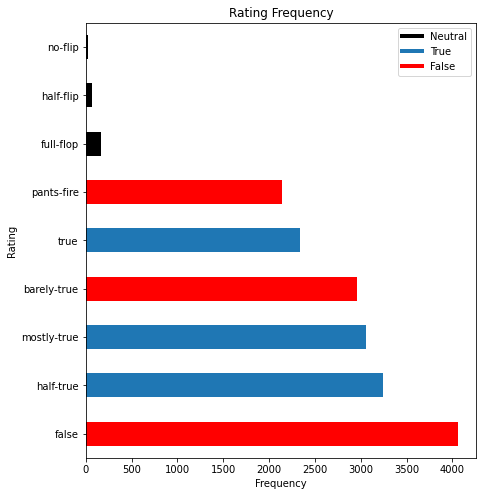

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,8))
ax = freq_rating.plot.barh(color = ['r','C0','C0','r','C0','r','k','k','k'])
ax.set_xlabel('Frequency')
ax.set_ylabel('Rating')
ax.set_title('Rating Frequency')
custom_lines = [Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='C0', lw=4),
                Line2D([0], [0], color='r', lw=4)]
ax.legend(custom_lines, ['Neutral', 'True','False'])
plt.show()

## Authors

In [ ]:
authors_freq = df.Author.value_counts()
num_auth = len(authors_freq)
print(f'There is a total of {num_auth} unique authors.')

There is a total of 4253 unique authors.


In [ ]:
num_freq_1_author = len(authors_freq[authors_freq.values == 1])
print(f'There is a total of {num_freq_1_author} unique authors with only one apperance.')

There is a total of 2616 unique authors with only one apperance.


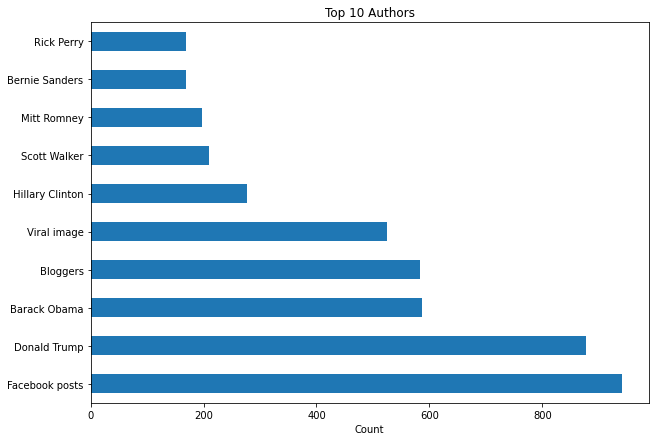

In [ ]:
#Top ten authors
top_authors_count = df.Author.value_counts()[:10]
fig, ax = plt.subplots(figsize=(10, 7))

ax = top_authors_count.plot.barh()
ax.set_xlabel('Count')
ax.set_title('Top 10 Authors')
plt.show()
fig.savefig(f'{PATH}plots/topauthors.pdf')

We can divide the dataset into two main categories True and False. All facts checks with ratings True, Mostly True or Half True are considered True. While all facts checks with ratigs Mostly False, False or Pants on Fire are considered False. 

Then we will evaluate who is the biggest liar and who is trustworthy. First we will eliminate all Authors with **less than 30 ratings**, since it is very likely that there some authors that have few ratings and thus they will easily appear as either big liars or trustworthy people. Finally we will divide their true/false number of ratings by their own individual number of ratings. This outcomes an score between 0 to 1. Value 1 implies that she/he is a complete liar or trustworthy person.

Two dictionaries will be created, worthy and liar, where each author score is annotated.

In [ ]:
''' Divide the Dataset '''

#True
true_list = ['true','mostly-true','half-true']

df_true = pd.DataFrame()
for t in true_list:
    df_true = df_true.append(df[df.Rating == t])


#False
false_list = ['false','barely-true','pants-fire']

df_false = pd.DataFrame()
for f in false_list:
    df_false = df_false.append(df[df.Rating == f])


#Compute worthy/liar score
authors = df.Author.value_counts()
authors_true = df_true.Author.value_counts()
authors_false = df_false.Author.value_counts()

worthy = {}
liar = {}
for a in authors.index:
    if a in authors_true.index and authors[a] > 30:
        worthy[a] = authors_true[a]/(authors_true[a]+authors_false[a])
    if a in authors_false.index and authors[a] > 30:
        liar[a] = authors_false[a]/(authors_true[a]+authors_false[a])

#Sort by score
worthy = {k: v for k, v in sorted(worthy.items(), key=lambda item: item[1], reverse =True)}
liar = {k: v for k, v in sorted(liar.items(), key=lambda item: item[1], reverse =True)}

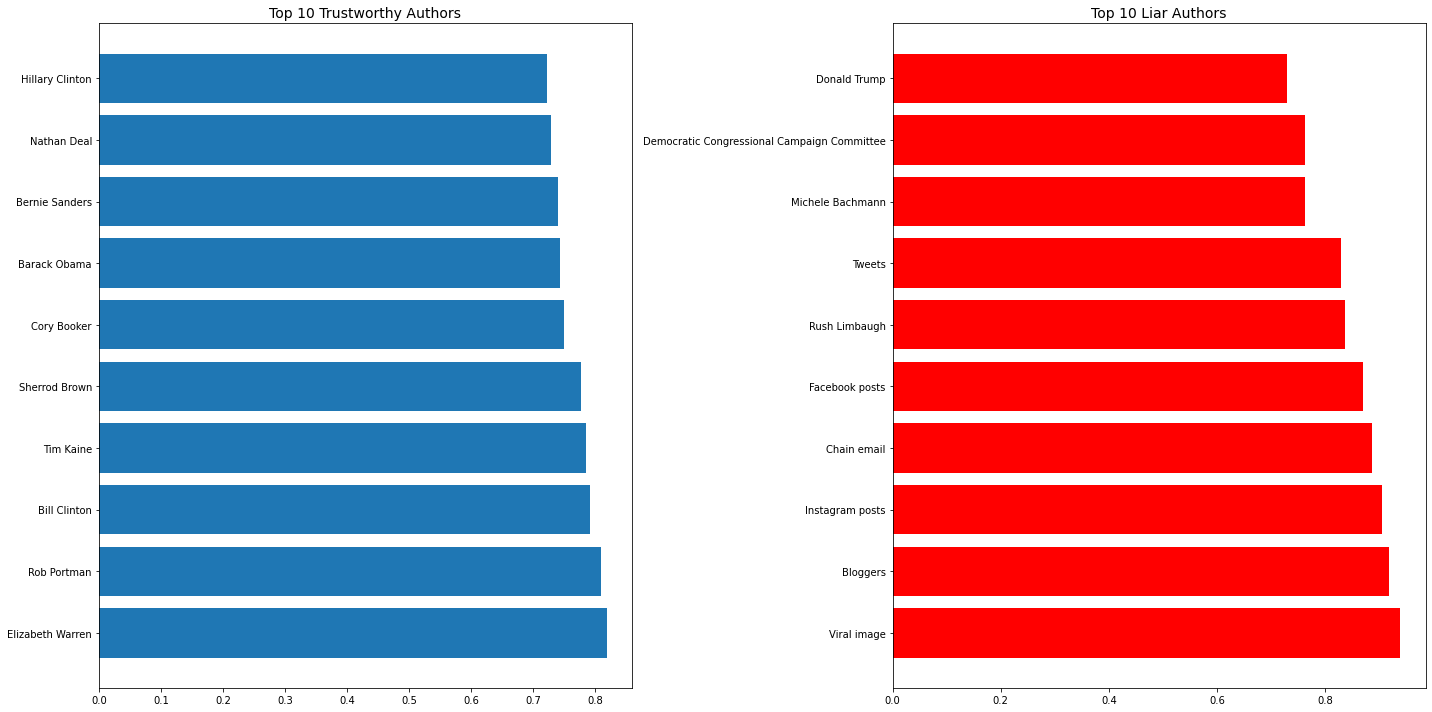

In [ ]:
#Top 10 worthy authors/values
worthy_authors = list(islice(worthy.keys(), 10))
worthy_values = list(islice(worthy.values(), 10))

#Top 10 liar authors/values
liar_authors = list(islice(liar.keys(), 10))
liar_values = list(islice(liar.values(), 10))

#Plot
fig, axes = plt.subplots(1,2,figsize=(20,10))

axes[0].barh(range(len(worthy_authors)),worthy_values,tick_label = worthy_authors)
axes[0].set_title('Top 10 Trustworthy Authors', size=14)

axes[1].barh(range(len(liar_authors)),liar_values,tick_label = liar_authors, color='r')
axes[1].set_title('Top 10 Liar Authors', size=14)
plt.tight_layout()
plt.show()

For each of the top 5 authors we will create a **pie plot** to show the percetange of liar and trustworthy score. **Next to the authors name there is the number of appearances of that author in Politifact website.**  

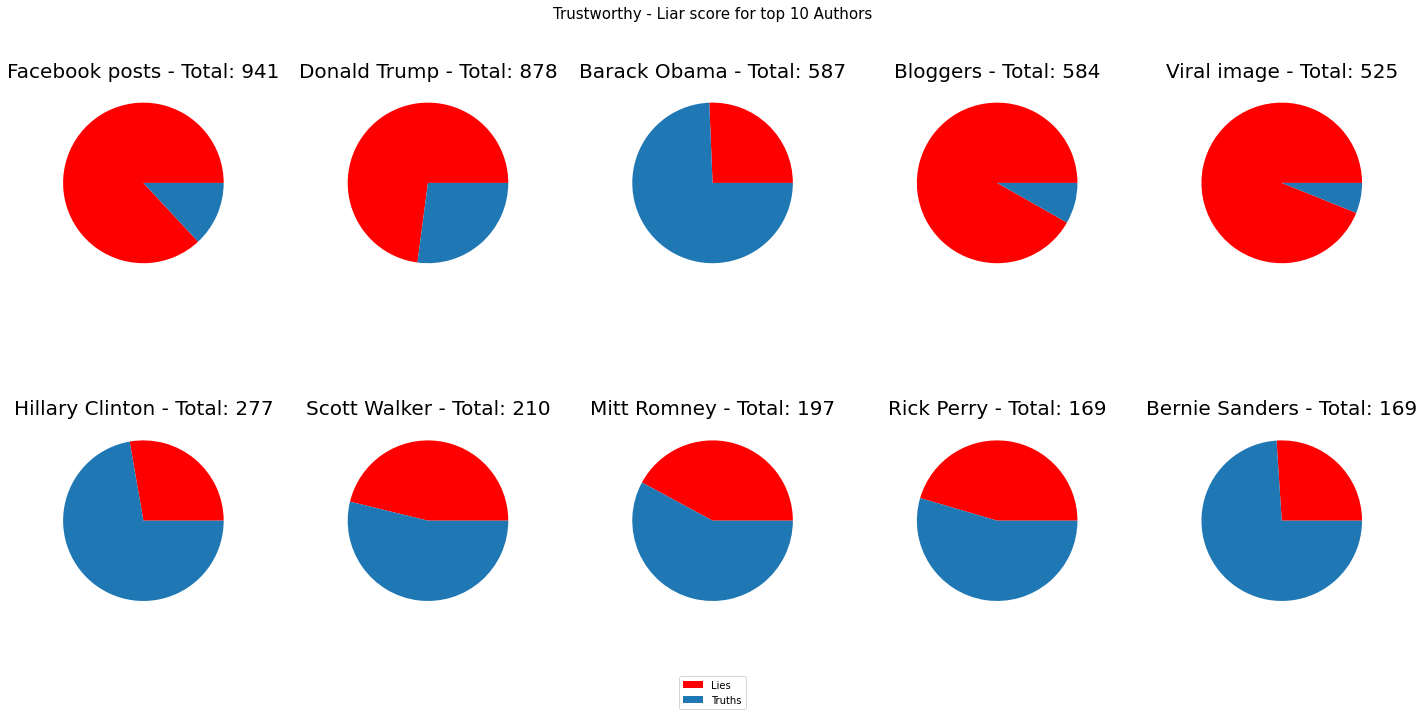

In [ ]:
fig, axes = plt.subplots(2,5,figsize=(20,10))
fig.suptitle('Trustworthy - Liar score for top 10 Authors', fontsize=15)
for ax, auth in zip(axes.flat, top_authors_count.index):
    ax.pie([liar[auth],worthy[auth]],
            colors = ['r','C0'],
            textprops={'fontsize': 14})
    ax.set_title(f'{auth} - Total: {top_authors_count[auth]}', size=20)
fig.legend(labels = ['Lies','Truths'],loc=8,prop={'size': 10})
fig.tight_layout()
plt.show()

## Title

We will create a text **scatter plot**  to show the most frequent and relevant words in the Titles. Using the library **scattertext**. **scattetext** generates an intereactive HTML file that allows us to search words and the respective tf-idf plus some more statistics are shown

In [ ]:
#Create new dataframe with new column Label taking values {'True', 'False'}
df_parser = df
df_parser['Label'] = 'Nan'

for index, row in df.iterrows():
    if row['Rating'] in ['true','mostly-true','half-true']:
        row['Label'] = 'True'
    elif row['Rating'] in ['false','barely-true','pants-fire']:
        row['Label'] = 'False'

In [ ]:
# Preprocessing of titles
nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))

def getTerms(terms):
    terms = terms.lower() 
    terms = terms.translate(str.maketrans("","", string.punctuation))
    terms = terms.split()
    terms = [t for t in terms if t not in STOPWORDS]
    terms = ' '.join(x for x in terms)
    return terms

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Preprocess, parse all titles save in new col
nlp = spacy.load('en')
df_parser['Parsed'] = df_parser['Title'].apply(lambda x: getTerms(x))
df_parser['Parsed'] = df_parser['Parsed'].apply(nlp)

In [ ]:
#Compute frequency of terms based on label
corpus = st.CorpusFromParsedDocuments(df_parser,category_col='Label', parsed_col='Parsed').build()

#Create Scatter plot in HTML
html = st.produce_scattertext_explorer(corpus,
                                    category='True',
                                    category_name='True Fact Checks',
                                    not_category_name='False Fact Checks',
                                    width_in_pixels=1000,
                                    height_in_pixels=1000,
                                    minimum_term_frequency=30,
                                    transform=st.Scalers.dense_rank,
                                    metadata=df_parser['Author'])

file_name = f'{PATH}/Title_scatterplot.html'
open(file_name, 'wb').write(html.encode('utf-8'))

2679871

In [ ]:
#Average length of Titles
avg_title_len = np.mean([len(x.split()) for x in df['Title'].values ])
print(f'The average Title length is {avg_title_len} words.')

The average Title length is 18.092516629711753 words.


## Tags

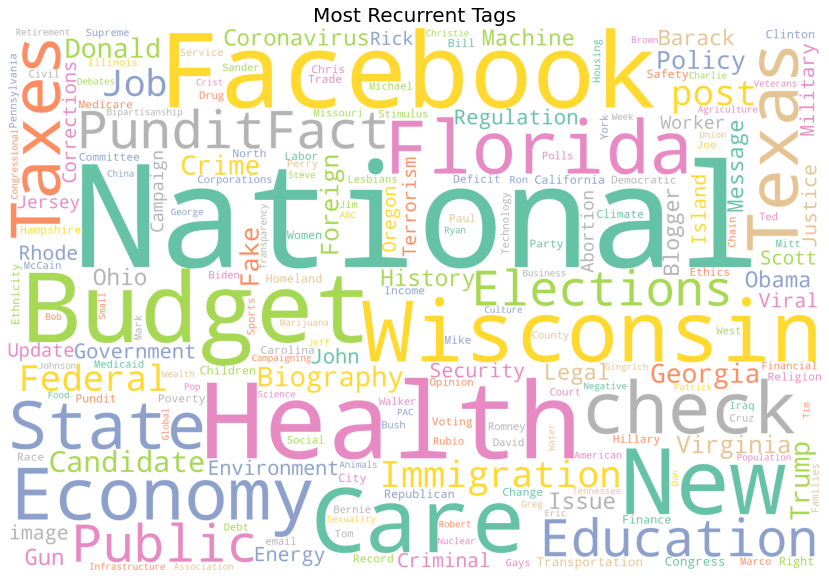

In [ ]:
#Transform all titles into one string
for index, row in df.iterrows():
    row['Tags'] = row['Tags'].replace(',',' ')
tags = ''.join(df.Tags.tolist())

#Words to be removed
stopwords = set(STOPWORDS)
stopwords.add('Fact')

#Create and plot wordcloud
wordcloud =  WordCloud(width = 3000, height = 2000,
                        random_state=1,
                        background_color='white', 
                        colormap='Set2', collocations=False, 
                        stopwords = stopwords).generate(tags)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Recurrent Tags', fontsize = 20)
plt.show()

We repeat the previous plot but now for **true fact** checks and for **false fact** checks.

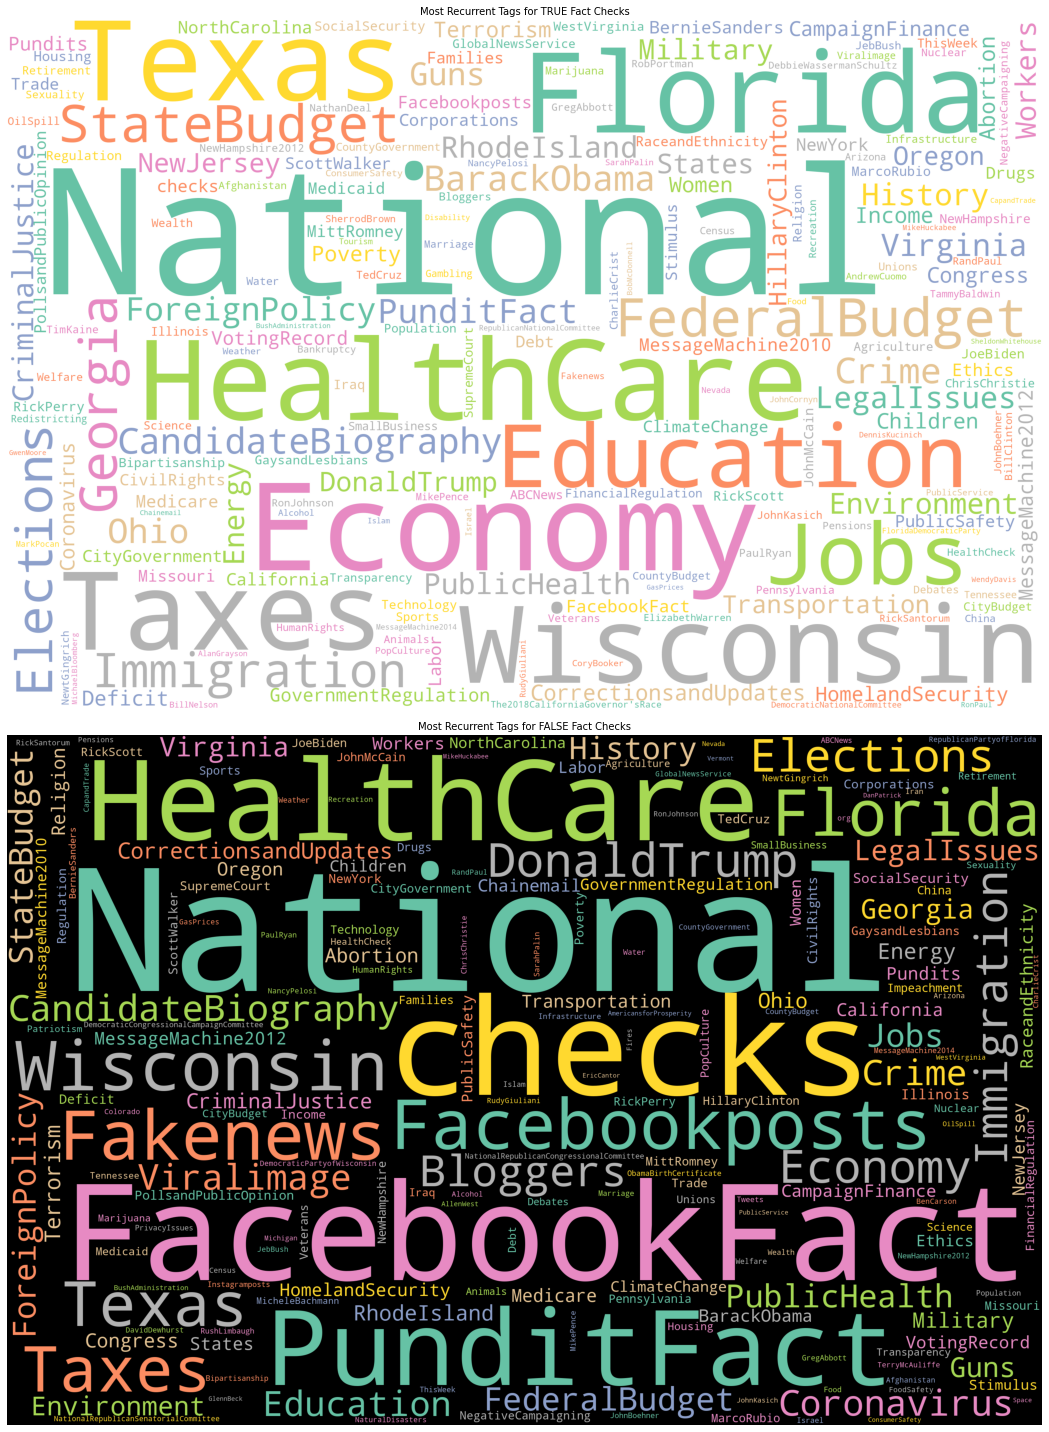

In [ ]:
#True fact checks
for index, row in df_true.iterrows():
    tags = row['Tags'].split(',')
    tags = ' '.join(x.replace(' ','') for x in tags)
    row['Tags'] = tags

true_tags = ''.join(df_true.Tags.tolist())
true_wordcloud =  WordCloud(width = 3000, height = 2000,
                        random_state=1,
                        background_color='white', 
                        colormap='Set2', collocations=False, 
                        stopwords = stopwords).generate(true_tags)
#False fact checks
for index, row in df_false.iterrows():
    tags = row['Tags'].split(',')
    tags = ' '.join(x.replace(' ','') for x in tags)
    row['Tags'] = tags
    
false_tags = ''.join(df_false.Tags.tolist())
false_wordcloud =  WordCloud(width = 3000, height = 2000,
                        random_state=1,
                        background_color='black', 
                        colormap='Set2', collocations=False, 
                        stopwords = stopwords).generate(false_tags)

#Plot
fig, axes = plt.subplots(2,1, figsize=(40,20))
axes[0].imshow(true_wordcloud)
axes[0].axis('off')
axes[0].set_title('Most Recurrent Tags for TRUE Fact Checks', fontsize=10)
axes[1].imshow(false_wordcloud)
axes[1].axis('off')
axes[1].set_title('Most Recurrent Tags for FALSE Fact Checks', fontsize=10)
fig.tight_layout()
fig.show()

In [ ]:
# Get Tags Frequency
def getFreqTags(data, topn = 20) :
    all_tags = []
    for t in data:
        all_tags.extend(t.split(' ')[:-1]) 
    
    freq_tags = Counter(all_tags)
    freq_tags = {k: v for k, v in sorted(freq_tags.items(), key=lambda item: item[1], reverse = True)}
    tags = list(islice(freq_tags.keys(), topn))
    frequency = list(islice(freq_tags.values(), topn))
    
    return tags, frequency, freq_tags

By using the splitted datasets we can see the most frequent tags in True and False news. The first plot shows the top 20 tags used in True news and the respective frequency of use for both True and False news. The second plot shows the top 20 tags used in False news and the respective frequency of use for both True and False news.

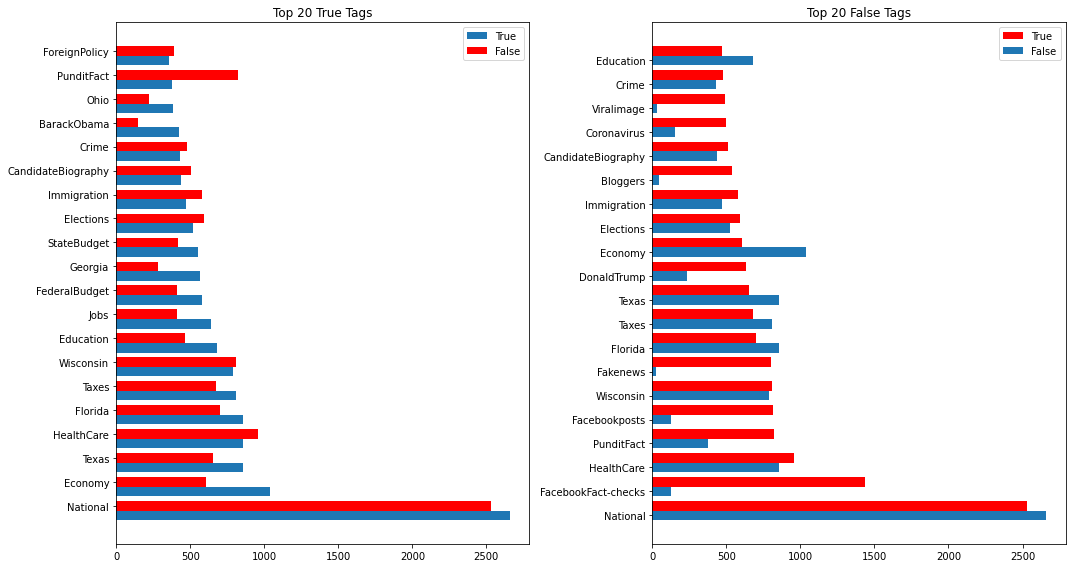

In [ ]:
#Tags Frequency per label
topn = 20
true_tags, true_tags_freq, all_true_tags_freq = getFreqTags(df_true['Tags'], topn)
false_tags, false_tags_freq, all_false_tags_freq = getFreqTags(df_false['Tags'], topn)

#Top true tags in false news
false_true_tags_freq = [all_false_tags_freq[x] for x in true_tags] 

#Top false tags in true news
true_false_tags_freq = [all_true_tags_freq[x] for x in false_tags] 


#Bar plot
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].barh(np.array(range(topn)),true_tags_freq,tick_label = true_tags, height=0.4)
ax[0].barh(np.array(range(topn))+0.4,false_true_tags_freq,tick_label = true_tags, height = 0.4,color='r')
ax[0].set_title(f'Top {topn} True Tags')
ax[0].legend(labels=['True','False'])

ax[1].barh(np.array(range(topn))+0.4,false_tags_freq,tick_label = false_tags, height=0.4, color = 'r')
ax[1].barh(np.array(range(topn)),true_false_tags_freq,tick_label = false_tags, height = 0.4)
ax[1].set_title(f'Top {topn} False Tags')
ax[1].legend(labels=['True','False'])

fig.tight_layout()
fig.show()

In [ ]:
#Top 10 author most associated tags
df_tags = df.copy()
for index, row in df_tags.iterrows():
    tags = row['Tags'].split(',')
    tags = ' '.join(x.replace(' ','') for x in tags)
    row['Tags'] = tags

top_author_tags = defaultdict(dict)
for auth in df_tags['Author'].value_counts().keys()[:10] :
    author_df = df_tags[df_tags['Author'] == auth]
    tags, freq, all_tags_freq = getFreqTags(author_df['Tags'], topn =10)
    auth_dic = {k:v for k,v in zip(tags,freq)}
    top_author_tags[auth] = auth_dic

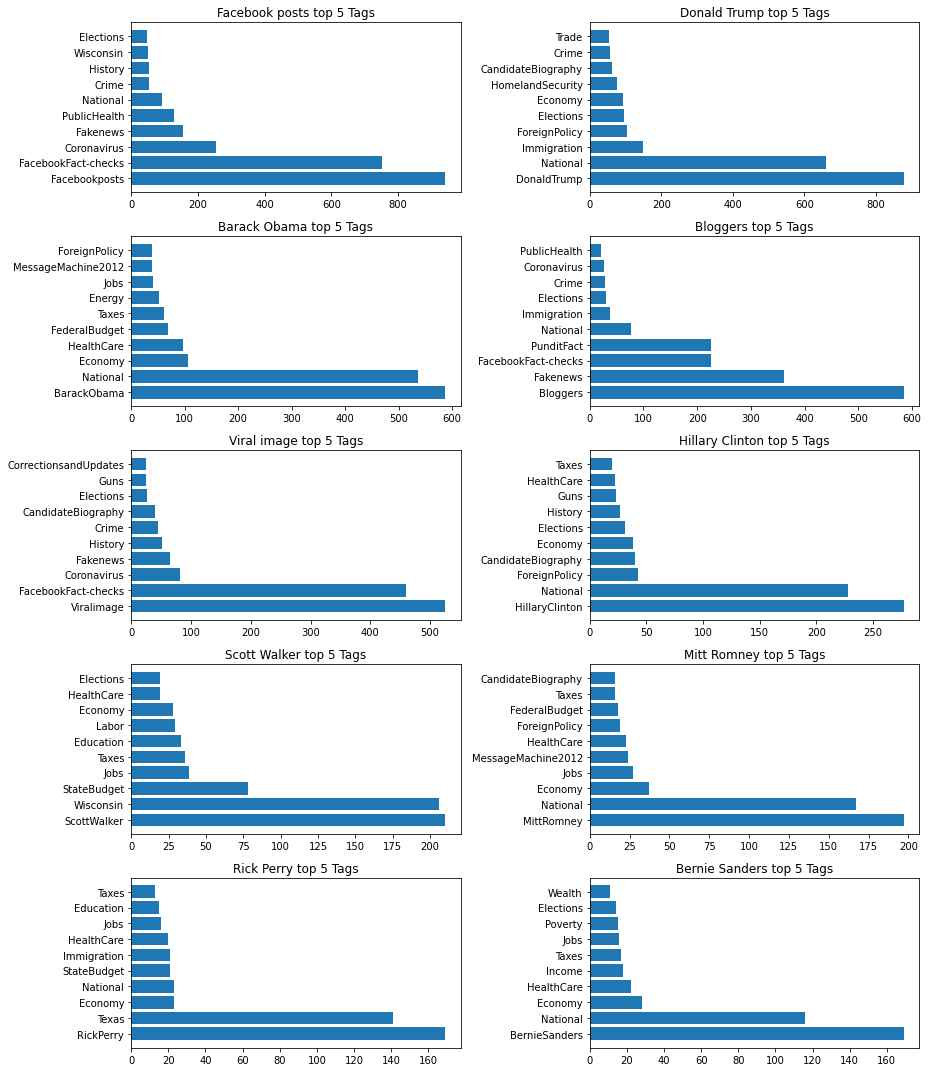

In [ ]:
fig, axes = plt.subplots(5,2, figsize=(13,15))

for ax,auth in zip(axes.flat, top_author_tags.keys()) :
    ax.barh(range(10), list(top_author_tags[auth].values()), tick_label = list(top_author_tags[auth].keys()))
    ax.set_title(f'{auth} top 5 Tags')

fig.tight_layout()

Analyzing the **disparity** in tags is a good assessment of how much information are going to provide to the classification model. A high disparity will be an indicator of noisy data and thus a bad classification performance. A low disparity will be an indicator of consistent data which may be an indicator of the good performance of the algorithm.

In [ ]:
# Tags Frequency num tags per news
num_tags_per_news = []
all_tags = []
for t in df['Tags'] :
    tags = t.split(',')
    tags = [x.replace(' ','') for x in tags][:-1]
    num_tags_per_news.append(len(tags))
    all_tags.extend(tags)

tags_freq = Counter(all_tags)

In [ ]:
# Number of tags with frequency equal to min_freq
def numTags_freq(tags_frequency, min_freq) :
    counter = 0
    for k,v in tags_frequency.items():
        if v == min_freq:
            counter += 1
    return counter

In [ ]:
num_tags = len(tags_freq)
print(f'There is a total of {num_tags} unique tags.\n')

for i in range(1,5) :
    count = numTags_freq(tags_freq, i)
    frac = (count/num_tags)*100
    print(f'There is a total of {count} tags with a frequency equal to {i} which represents {frac}% of all unique tags.')

avg_num_tags = np.mean(num_tags_per_news)
std_num_tags = np.std(num_tags_per_news)
print(f'\n Each data entry has on average {avg_num_tags} tags with a standar deviation of {std_num_tags}.')

There is a total of 4428 unique tags.

There is a total of 2617 tags with a frequency equal to 1 which represents 59.10117434507678% of all unique tags.
There is a total of 661 tags with a frequency equal to 2 which represents 14.927732610659438% of all unique tags.
There is a total of 280 tags with a frequency equal to 3 which represents 6.323396567299007% of all unique tags.
There is a total of 161 tags with a frequency equal to 4 which represents 3.635953026196929% of all unique tags.

 Each data entry has on average 4.002716186252772 tags with a standar deviation of 1.2436282594125152.
